In [1]:
import src.explainers as exp
import matplotlib.pyplot as plt

In [84]:
import importlib
importlib.reload(exp)

<module 'src.explainers' from '/home/mikesmac/Downloads/GraphSVX/src/explainers.py'>

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data

dataset = Planetoid(root='/tmp/Cora', name='Cora')
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
x = dataset[0].x[:,:64].cuda()
edge_index = dataset[0].edge_index.cuda()
y = dataset[0].y.cuda()

In [4]:
y = torch.rand(y.shape[0], 1).cuda()

In [5]:
data = dataset[0]
data = Data(x=x, y=y, edge_index=edge_index).cuda()


In [50]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(64, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data = data.to(device)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()

In [104]:
torch.nn.functional

tensor([[0.1975],
        [0.1961],
        [0.1962],
        [0.2160],
        [0.1942]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [85]:
data.num_classes = 1
e = exp.GraphSVX(data.cpu(), model, gpu=True)

In [93]:
shap_values, base_value = e.explain(node_indexes=[1], num_samples=10, multiclass=True, args_feat='All', info=True, target_type='class')

10it [00:00, 477.14it/s]

WLS: Matrix not invertible
r2:  0.6549161105640062
weighted r2:  0.9999998968012147
Explanations include 64 node features and 8 neighbours for this node            for 1 classes
Model prediction is class 0 with confidence 1.633583426475525, while true label is tensor([0.2793])
Base value [1.5993172] for class  0
Weights for node features:  0.038291650991595816 and neighbours:  -0.0040266066789627075
Most influential features:  6 and neighbours 0
Most influential features:  [(47, 0.050721168518066406), (53, -0.03208637237548828), (39, 0.021651148796081543)]
Most influential neighbours:  [(332, -0.0030812621116638184), (1666, -0.002357304096221924), (470, 0.0017642751336097717)]
Time:  0.08465576171875



/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.3889e-02, 1.3889e-02, 1.0000e+03, 1.3889e-02, 1.0000e+03, 3.4295e-22,
        1.3889e-02, 1.3889e-02, 1.3889e-02, 1.3889e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [94]:
shap_values[0].sum()+base_value

array([1.63358224])

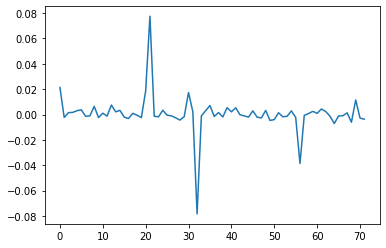

In [92]:
plt.plot(shap_values[0])

In [116]:
pred_class_3 = (pred==3).nonzero().flatten().detach().cpu().numpy()

In [117]:
pred_class_3

array([   0,    7,    8,   13,   14,   15,   17,   19,   21,   24,   25,
         27,   30,   32,   40,   44,   45,   48,   51,   57,  131,  143,
        147,  150,  157,  158,  159,  160,  164,  165,  169,  171,  178,
        180,  182,  183,  184,  185,  186,  201,  205,  207,  208,  218,
        219,  223,  224,  228,  229,  230,  231,  232,  235,  237,  248,
        251,  253,  255,  260,  261,  266,  269,  277,  278,  279,  281,
        288,  291,  292,  295,  296,  297,  298,  310,  311,  313,  316,
        319,  321,  322,  327,  329,  332,  333,  335,  336,  338,  343,
        345,  351,  352,  365,  368,  386,  390,  396,  398,  402,  411,
        414,  418,  421,  430,  435,  450,  453,  457,  460,  470,  480,
        481,  482,  486,  492,  493,  495,  500,  507,  508,  510,  511,
        517,  518,  520,  531,  532,  538,  549,  558,  566,  568,  571,
        575,  579,  593,  598,  599,  600,  601,  606,  618,  622,  625,
        628,  633,  637,  640,  652,  658,  665,  6

In [121]:
for i in pred_class_3:
    shap_values = e.explain(node_indexes=[int(i)], num_samples=10, args_feat='All')

10it [00:00, 60.27it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.4085e-02, 1.4085e-02, 1.4085e-02, 1.4085e-02, 2.6586e-22,
        1.4085e-02, 1.0000e+03, 1.4085e-02, 1.4085e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.67it/s]

WLS: Matrix not invertible
r2:  0.8537512808896754
weighted r2:  0.9999999799750271
Explanations include 64 node features and 7 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9945772290229797, while true label is 3
Base value 0.21543190632183684 for class  3
Weights for node features:  0.440963186792942 and neighbours:  0.3381814695894718
Most influential features:  6 and neighbours 0
Most influential features:  [(43, 2.559359550476074), (26, -1.5127778053283691), (46, -0.8114676475524902)]
Most influential neighbours:  [(1862, 0.20479917526245117), (1166, 0.041142113506793976), (2582, 0.03191889822483063)]
Time:  0.20642757415771484


10it [00:00, 60.38it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.5385e-02, 1.0000e+03, 1.0000e+03, 1.5385e-02, 1.5385e-02, 1.5385e-02,
        1.5385e-02, 1.5385e-02, 1.5385e-02, 1.7873e-20], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.02it/s]

WLS: Matrix not invertible
r2:  0.08469669957554049
weighted r2:  0.9999999298717079
Explanations include 64 node features and 1 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8819229602813721, while true label is 3
Base value 0.21543223314773607 for class  3
Weights for node features:  0.6547343477795948 and neighbours:  0.01175619661808014
Most influential features:  6 and neighbours 0
Most influential features:  [(36, 1.031334400177002), (9, -0.3756664991378784), (59, -0.359588623046875)]
Time:  0.2042388916015625


10it [00:00, 59.94it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2195e-02, 1.2195e-02, 2.7682e-25, 1.2195e-02, 1.0000e+03, 1.2195e-02,
        1.0000e+03, 1.2195e-02, 1.2195e-02, 1.2195e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.5869872199555137
weighted r2:  0.9999999851508835
Explanations include 64 node features and 18 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8986456394195557, while true label is 3
Base value 0.21543201793411726 for class  3
Weights for node features:  0.6092924147442318 and neighbours:  0.07392122410237789
Most influential features:  3 and neighbours 3
Most influential features:  [(10, 0.5205733776092529), (42, 0.07761585712432861), (63, 0.011397091455364716)]
Most influential neighbours:  [(1347, 0.023409366607666016), (2543, 0.023325681686401367), (321, 0.0197991281747818)]
Time:  0.21086382865905762


10it [00:00, 51.47it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([5.5866e-03, 5.5866e-03, 5.5866e-03, 5.5866e-03, 1.0000e-40, 1.0000e+03,
        5.5866e-03, 1.0000e+03, 5.5866e-03, 5.5866e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 57.52it/s]

WLS: Matrix not invertible
r2:  0.7151200335368539
weighted r2:  0.9999999861973413
Explanations include 64 node features and 115 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.6034632325172424, while true label is 3
Base value 0.21543198979831357 for class  3
Weights for node features:  0.5988700303969381 and neighbours:  -0.2108447292685014
Most influential features:  3 and neighbours 3
Most influential features:  [(60, 0.27874088287353516), (28, 0.17687582969665527), (16, 0.08397150039672852)]
Most influential neighbours:  [(24, -0.14844775199890137), (1865, -0.11592245101928711), (1075, -0.053826093673706055)]
Time:  0.3323242664337158


10it [00:00, 57.19it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([8.5470e-03, 8.5470e-03, 1.0000e+03, 2.7835e-36, 8.5470e-03, 8.5470e-03,
        8.5470e-03, 8.5470e-03, 8.5470e-03, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.20it/s]

WLS: Matrix not invertible
r2:  0.9994218637044452
weighted r2:  0.9999999865661529
Explanations include 64 node features and 53 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.6746512651443481, while true label is 3
Base value 0.21543188323516665 for class  3
Weights for node features:  0.47693809018437605 and neighbours:  -0.01771812356855662
Most influential features:  5 and neighbours 1
Most influential features:  [(55, 0.6828384399414062), (63, -0.06152844429016113), (33, -0.0588984489440918)]
Most influential neighbours:  [(2075, -0.04640096426010132), (1020, 0.01572728157043457), (1319, 0.009687542915344238)]
Time:  0.22235512733459473


10it [00:00, 60.13it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2500e-02, 1.0000e+03, 1.1466e-24, 1.0000e+03, 1.2500e-02, 1.2500e-02,
        1.2500e-02, 1.2500e-02, 1.2500e-02, 1.2500e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.26it/s]

WLS: Matrix not invertible
r2:  0.5869383741884913
weighted r2:  0.9999880384168774
Explanations include 64 node features and 16 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9024686813354492, while true label is 3
Base value 0.2154359942407369 for class  3
Weights for node features:  0.4850692123227418 and neighbours:  0.20196477354511444
Most influential features:  3 and neighbours 3
Most influential features:  [(26, 0.3681459426879883), (4, 0.10435819625854492), (14, 0.027709782123565674)]
Most influential neighbours:  [(2367, 0.2869459458615893), (894, -0.0370333194732666), (2177, -0.02794337272644043)]
Time:  0.2070939540863037


10it [00:00, 60.17it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2987e-02, 1.0000e+03, 1.0000e+03, 1.2987e-02, 1.2987e-02, 1.2987e-02,
        4.4134e-24, 1.2987e-02, 1.2987e-02, 1.2987e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.70it/s]

WLS: Matrix not invertible
r2:  0.933793523563514
weighted r2:  0.9999999822896286
Explanations include 64 node features and 13 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.6812123656272888, while true label is 3
Base value 0.21543207916439833 for class  3
Weights for node features:  0.40458103688888514 and neighbours:  0.06119821242100443
Most influential features:  5 and neighbours 1
Most influential features:  [(3, -0.3252997398376465), (20, 0.23352879285812378), (62, 0.20109689235687256)]
Most influential neighbours:  [(1301, 0.12331491708755493), (927, -0.10477608442306519), (24, -0.04794226586818695)]
Time:  0.2066812515258789


10it [00:00, 60.41it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.5152e-02, 1.5152e-02, 1.5152e-02, 1.5152e-02, 1.0910e-20, 1.5152e-02,
        1.5152e-02, 1.0000e+03, 1.5152e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  -0.21878974264808093
weighted r2:  0.9999993222345266
Explanations include 64 node features and 2 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.26254796981811523, while true label is 3
Base value 0.21543194997172285 for class  3
Weights for node features:  0.04648405155558066 and neighbours:  0.0006314441561698914
Most influential features:  6 and neighbours 0
Most influential features:  [(39, 0.01788860559463501), (47, 0.010067749077279586), (7, 0.00812503695487976)]
Time:  0.20375347137451172


10it [00:00, 60.23it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4706e-02, 1.4706e-02, 1.4706e-02, 2.0370e-21, 1.4706e-02, 1.0000e+03,
        1.4706e-02, 1.4706e-02, 1.0000e+03, 1.4706e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
5it [00:00, 46.78it/s]

WLS: Matrix not invertible
r2:  0.2504811296634323
weighted r2:  0.9999996854295036
Explanations include 64 node features and 4 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.4208243489265442, while true label is 3
Base value 0.2154322268866185 for class  3
Weights for node features:  0.04667196540685836 and neighbours:  0.15871582925319672
Most influential features:  5 and neighbours 1
Most influential features:  [(21, -0.7180213928222656), (1, 0.4468073844909668), (5, -0.4339118003845215)]
Time:  0.2639274597167969


10it [00:00, 48.14it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e-40, 5.8480e-03, 5.8480e-03, 5.8480e-03, 1.0000e+03, 1.0000e+03,
        5.8480e-03, 5.8480e-03, 5.8480e-03, 5.8480e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.66it/s]

WLS: Matrix not invertible
r2:  0.9310686928054004
weighted r2:  0.9999999930814885
Explanations include 64 node features and 107 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8168663382530212, while true label is 3
Base value 0.21543197567893713 for class  3
Weights for node features:  -0.9589440381023451 and neighbours:  1.5603873049622052
Most influential features:  3 and neighbours 3
Most influential features:  [(0, -0.7799749374389648), (38, -0.45765113830566406), (40, 0.29059839248657227)]
Most influential neighbours:  [(521, 1.138040542602539), (1863, 0.4086036682128906), (1877, 0.26238536834716797)]
Time:  0.265183687210083


10it [00:00, 60.38it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2500e-02, 1.0000e+03, 1.2500e-02, 1.2500e-02, 1.2500e-02, 8.6629e-25,
        1.0000e+03, 1.2500e-02, 1.2500e-02, 1.2500e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 56.62it/s]

WLS: Matrix not invertible
r2:  -11.613862118893195
weighted r2:  0.9999999818746917
Explanations include 64 node features and 16 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.87796550989151, while true label is 3
Base value 0.21543191575038145 for class  3
Weights for node features:  -1.9414211396833707 and neighbours:  2.6039724025686155
Most influential features:  5 and neighbours 1
Most influential features:  [(42, -5.02356481552124), (27, -1.1182262301445007), (51, 1.0745143294334412)]
Most influential neighbours:  [(2315, 2.8622593879699707), (2317, 0.7573426365852356), (1301, -0.7071441411972046)]
Time:  0.20694470405578613


10it [00:00, 57.17it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([8.6207e-03, 8.6207e-03, 8.6207e-03, 8.6207e-03, 8.6207e-03, 3.1968e-35,
        1.0000e+03, 1.0000e+03, 8.6207e-03, 8.6207e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
5it [00:00, 44.32it/s]

WLS: Matrix not invertible
r2:  0.8058870420946066
weighted r2:  0.9999998088888054
Explanations include 64 node features and 52 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.661080539226532, while true label is 3
Base value 0.21543220421514853 for class  3
Weights for node features:  -0.03955874287203187 and neighbours:  0.4852066405746882
Most influential features:  3 and neighbours 3
Most influential features:  [(39, -0.10878467559814453), (2, 0.04684403750434285), (43, 0.0464940071105957)]
Most influential neighbours:  [(835, 0.34125661849975586), (1820, 0.08747482299804688), (1821, 0.04523444175720215)]
Time:  0.22198724746704102


10it [00:00, 45.77it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([3.8610e-03, 3.8610e-03, 3.8610e-03, 3.8610e-03, 1.0000e-40, 3.8610e-03,
        3.8610e-03, 3.8610e-03, 1.0000e+03, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  -153.02020947939894
weighted r2:  0.99999953848143
Explanations include 64 node features and 195 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.888822078704834, while true label is 3
Base value 0.21543193243543346 for class  3
Weights for node features:  5.786695748567581 and neighbours:  -5.112982135615312
Most influential features:  1 and neighbours 5
Most influential features:  [(27, 8.350452423095703), (57, -4.196474075317383), (7, 1.5571660995483398)]
Most influential neighbours:  [(686, 20.372276306152344), (154, 6.8996124267578125), (1284, 6.6947479248046875)]
Time:  0.305492639541626


10it [00:00, 59.76it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0526e-02, 1.0526e-02, 1.0000e+03, 1.0526e-02, 1.0526e-02, 1.0526e-02,
        1.0526e-02, 1.0526e-02, 1.2950e-29, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.81it/s]

WLS: Matrix not invertible
r2:  0.9169458612790027
weighted r2:  0.9999996674135848
Explanations include 64 node features and 31 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.26369404792785645, while true label is 0
Base value 0.21543199451077022 for class  3
Weights for node features:  0.07306540345598478 and neighbours:  -0.02480360120534897
Most influential features:  4 and neighbours 2
Most influential features:  [(34, 0.06168556213378906), (42, 0.055753231048583984), (16, -0.036579132080078125)]
Most influential neighbours:  [(1683, -0.08793830871582031), (779, 0.06440925598144531), (1973, 0.016691207885742188)]
Time:  0.2685415744781494


10it [00:00, 60.58it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.1765e-02, 1.1765e-02, 1.0000e+03, 1.1765e-02, 1.1765e-02, 1.1765e-02,
        1.1765e-02, 1.1765e-02, 1.0000e+03, 1.4015e-26], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.79it/s]

WLS: Matrix not invertible
r2:  0.577081673390258
weighted r2:  0.9999999995523712
Explanations include 64 node features and 21 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9496179223060608, while true label is 3
Base value 0.21543191693741526 for class  3
Weights for node features:  -5.5790734515176155 and neighbours:  6.313269853591919
Most influential features:  5 and neighbours 1
Most influential features:  [(36, -2.554187774658203), (34, -2.334932327270508), (57, 1.5644550323486328)]
Most influential neighbours:  [(1941, 5.200614929199219), (1176, 0.5931768417358398), (402, 0.5622091293334961)]
Time:  0.20847201347351074


10it [00:00, 60.57it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.4925e-02, 1.4925e-02, 1.4925e-02, 1.0000e+03, 1.4925e-02,
        1.4925e-02, 4.1348e-21, 1.4925e-02, 1.4925e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 52.22it/s]

WLS: Matrix not invertible
r2:  0.3815159456170022
weighted r2:  0.9999903988207947
Explanations include 64 node features and 3 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.99094557762146, while true label is 3
Base value 0.21543647255460552 for class  3
Weights for node features:  0.46353660987898593 and neighbours:  0.31197476024152593
Most influential features:  5 and neighbours 1
Most influential features:  [(40, 0.4484577178955078), (19, 0.026773397345095873), (57, -0.0067988942860210955)]
Time:  0.2046523094177246


10it [00:00, 53.64it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([5.9524e-03, 1.0000e+03, 5.9524e-03, 5.9524e-03, 1.0000e-40, 5.9524e-03,
        5.9524e-03, 5.9524e-03, 1.0000e+03, 5.9524e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.9977520210449706
weighted r2:  0.999999966078162
Explanations include 64 node features and 104 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8343189358711243, while true label is 3
Base value 0.21543206749624044 for class  3
Weights for node features:  0.05717625587180919 and neighbours:  0.561709112042081
Most influential features:  1 and neighbours 5
Most influential features:  [(38, 0.028506093847681768), (17, 0.02552509307861328), (45, -0.004474874585866928)]
Most influential neighbours:  [(1697, 0.6654319763183594), (460, -0.04375159740447998), (2541, -0.041628405431765714)]
Time:  0.2426137924194336


10it [00:00, 57.31it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([8.4746e-03, 8.4746e-03, 8.4746e-03, 8.4746e-03, 8.4746e-03, 1.4037e-36,
        8.4746e-03, 1.0000e+03, 8.4746e-03, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.80it/s]

WLS: Matrix not invertible
r2:  0.5015740571993648
weighted r2:  0.9999999997822318
Explanations include 64 node features and 54 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8645543456077576, while true label is 3
Base value 0.2154319361914518 for class  3
Weights for node features:  0.49909926379768876 and neighbours:  0.1500211294114706
Most influential features:  3 and neighbours 3
Most influential features:  [(33, 0.5994291305541992), (14, 0.18803691864013672), (0, -0.06754660606384277)]
Most influential neighbours:  [(1573, 0.07823300361633301), (1666, -0.06465578079223633), (2206, 0.04181206226348877)]
Time:  0.2808051109313965


10it [00:00, 60.57it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.3333e-02, 1.3333e-02, 1.7963e-23, 1.3333e-02, 1.3333e-02, 1.3333e-02,
        1.0000e+03, 1.3333e-02, 1.3333e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.70it/s]

WLS: Matrix not invertible
r2:  0.6949176364775472
weighted r2:  0.9999986176897196
Explanations include 64 node features and 11 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8100179433822632, while true label is 3
Base value 0.2154307062815921 for class  3
Weights for node features:  0.46154833762557246 and neighbours:  0.13303726884987555
Most influential features:  5 and neighbours 1
Most influential features:  [(34, 0.22972989082336426), (46, -0.04809701442718506), (18, 0.04552185535430908)]
Most influential neighbours:  [(421, 0.09561247352030477), (2215, 0.01813545823097229), (2213, -0.014103129506111145)]
Time:  0.2052321434020996


10it [00:00, 60.51it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([7.9914e-22, 1.4286e-02, 1.4286e-02, 1.4286e-02, 1.4286e-02, 1.0000e+03,
        1.0000e+03, 1.4286e-02, 1.4286e-02, 1.4286e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.46it/s]

WLS: Matrix not invertible
r2:  -0.39976105876447954
weighted r2:  0.9999999138757032
Explanations include 64 node features and 6 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5573774576187134, while true label is 3
Base value 0.2154320500489768 for class  3
Weights for node features:  0.35544342063440126 and neighbours:  -0.013497240841388702
Most influential features:  5 and neighbours 1
Most influential features:  [(0, 0.5161123275756836), (6, -0.09246611595153809), (38, 0.057554006576538086)]
Most influential neighbours:  [(1293, -0.04469788074493408), (572, 0.031613826751708984), (65, -0.02858664095401764)]
Time:  0.20561718940734863


10it [00:00, 60.31it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4085e-02, 1.4085e-02, 1.4085e-02, 1.4085e-02, 1.0000e+03, 1.4085e-02,
        1.4085e-02, 1.0000e+03, 1.4085e-02, 2.6586e-22], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 52.38it/s]

WLS: Matrix not invertible
r2:  0.7161756406352544
weighted r2:  0.9999930373305423
Explanations include 64 node features and 7 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5580409169197083, while true label is 1
Base value 0.21543348631580445 for class  3
Weights for node features:  0.3375802799473604 and neighbours:  0.00502894821420341
Most influential features:  4 and neighbours 2
Most influential features:  [(53, 0.22545114159584045), (42, 0.10220611095428467), (40, -0.08407628536224365)]
Most influential neighbours:  [(1547, -0.12025784512206883), (834, 0.09255427122116089), (1546, 0.02178850769996643)]
Time:  0.20574641227722168


10it [00:00, 53.33it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([6.1350e-03, 6.1350e-03, 6.1350e-03, 6.1350e-03, 6.1350e-03, 6.1350e-03,
        1.0000e+03, 1.0000e-40, 1.0000e+03, 6.1350e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  -0.0392486412331805
weighted r2:  0.9999992473190398
Explanations include 64 node features and 99 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5746115446090698, while true label is 3
Base value 0.2154315265020615 for class  3
Weights for node features:  -0.15401643757650163 and neighbours:  0.513199777011323
Most influential features:  3 and neighbours 3
Most influential features:  [(52, -0.10685300827026367), (58, -0.07740354537963867), (43, 0.06967782974243164)]
Most influential neighbours:  [(1856, 0.16428208351135254), (1862, 0.14771652221679688), (1473, 0.09550166130065918)]
Time:  0.24422216415405273


10it [00:00, 60.18it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([2.8745e-22, 1.3514e-02, 1.0000e+03, 1.3514e-02, 1.3514e-02, 1.0000e+03,
        1.3514e-02, 1.3514e-02, 1.3514e-02, 1.3514e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.12it/s]

WLS: Matrix not invertible
r2:  0.20217319474471462
weighted r2:  0.9999983142204052
Explanations include 64 node features and 10 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.2584296762943268, while true label is 3
Base value 0.21543206886379973 for class  3
Weights for node features:  0.04142681169651041 and neighbours:  0.001570947002619505
Most influential features:  5 and neighbours 1
Most influential features:  [(62, 0.020010650157928467), (25, 0.013279001683258684), (56, 0.007781139938742854)]
Most influential neighbours:  [(1015, 0.002897799015045166), (1976, -0.0007075835019350052), (2335, -0.0006579607725143433)]
Time:  0.26268458366394043


10it [00:00, 60.11it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.1905e-02, 1.1905e-02, 1.1905e-02, 1.0000e+03, 1.1905e-02, 1.1905e-02,
        1.1905e-02, 2.8709e-26, 1.1905e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 51.62it/s]

WLS: Matrix not invertible
r2:  0.8890294443271405
weighted r2:  0.9999998506185787
Explanations include 64 node features and 20 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5074864029884338, while true label is 3
Base value 0.21543209185362028 for class  3
Weights for node features:  0.29413243908362574 and neighbours:  -0.002077693701721728
Most influential features:  5 and neighbours 1
Most influential features:  [(58, 0.25174498558044434), (38, 0.035667982775578366), (39, 0.005278894276898427)]
Most influential neighbours:  [(352, -0.0017864704132080078), (1945, 0.0012245308607816696), (1950, -0.0007467949762940407)]
Time:  0.20804905891418457


10it [00:00, 53.14it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([6.0606e-03, 1.0000e-40, 1.0000e+03, 1.0000e+03, 6.0606e-03, 6.0606e-03,
        6.0606e-03, 6.0606e-03, 6.0606e-03, 6.0606e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
5it [00:00, 48.91it/s]

WLS: Matrix not invertible
r2:  0.9980823964676501
weighted r2:  0.9999999812739178
Explanations include 64 node features and 101 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.40497204661369324, while true label is 3
Base value 0.21543194950546246 for class  3
Weights for node features:  0.18918753694742918 and neighbours:  0.00035043743810092565
Most influential features:  5 and neighbours 1
Most influential features:  [(5, 0.13713932037353516), (30, 0.027779579162597656), (45, 0.019613981246948242)]
Most influential neighbours:  [(1862, 0.006028540461556986), (215, -0.004799156819899508), (1821, -0.003409266471862793)]
Time:  0.2451770305633545


10it [00:00, 51.35it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([5.3476e-03, 5.3476e-03, 5.3476e-03, 1.0000e+03, 5.3476e-03, 5.3476e-03,
        5.3476e-03, 1.0000e-40, 1.0000e+03, 5.3476e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.57it/s]

WLS: Matrix not invertible
r2:  0.8102154294560793
weighted r2:  0.9999999981994613
Explanations include 64 node features and 123 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5529738664627075, while true label is 3
Base value 0.2154319336871634 for class  3
Weights for node features:  0.41030814403347904 and neighbours:  -0.07276619002368534
Most influential features:  3 and neighbours 3
Most influential features:  [(10, -0.25722169876098633), (29, 0.2498154640197754), (50, 0.23107075691223145)]
Most influential neighbours:  [(767, -0.18123316764831543), (2036, 0.14666247367858887), (2130, -0.12673401832580566)]
Time:  0.25415706634521484


10it [00:00, 60.37it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.2821e-02, 1.0000e+03, 1.2821e-02, 1.2821e-02, 1.2821e-02,
        6.6883e-24, 1.2821e-02, 1.2821e-02, 1.2821e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.9938048347065878
weighted r2:  0.9999999889554952
Explanations include 64 node features and 14 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.7349947690963745, while true label is 3
Base value 0.21543196937861142 for class  3
Weights for node features:  0.5099625787770492 and neighbours:  0.009598897991509148
Most influential features:  4 and neighbours 2
Most influential features:  [(26, 0.5511288642883301), (49, -0.07160186767578125), (4, -0.033991336822509766)]
Most influential neighbours:  [(2037, -0.029620260000228882), (791, 0.028492778539657593), (2308, 0.016057372093200684)]
Time:  0.20703792572021484


10it [00:00, 55.40it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([7.0922e-03, 7.0922e-03, 7.0922e-03, 7.0922e-03, 1.0000e+03, 7.0922e-03,
        1.0000e-40, 7.0922e-03, 1.0000e+03, 7.0922e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.83it/s]

WLS: Matrix not invertible
r2:  0.3182622695858842
weighted r2:  0.999999996708382
Explanations include 64 node features and 77 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.43309304118156433, while true label is 3
Base value 0.2154319076173119 for class  3
Weights for node features:  -0.8970756066846661 and neighbours:  1.1147387133387383
Most influential features:  2 and neighbours 4
Most influential features:  [(5, -1.58746337890625), (41, 0.6961212158203125), (32, -0.12936806678771973)]
Most influential neighbours:  [(71, 0.4309196472167969), (681, 0.42847537994384766), (232, -0.4102659225463867)]
Time:  0.2894308567047119


10it [00:00, 60.59it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2658e-02, 1.2658e-02, 1.2658e-02, 1.2658e-02, 1.0000e+03, 1.2658e-02,
        1.2658e-02, 1.0000e+03, 9.3017e-25, 1.2658e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 58.48it/s]

WLS: Matrix not invertible
r2:  0.5804700388139615
weighted r2:  0.9999997814542955
Explanations include 64 node features and 15 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.33113235235214233, while true label is 0
Base value 0.21543199135454977 for class  3
Weights for node features:  0.09914420643144695 and neighbours:  0.01655694302644406
Most influential features:  4 and neighbours 2
Most influential features:  [(42, 0.055889129638671875), (57, 0.03551197052001953), (25, 0.01257725409050181)]
Most influential neighbours:  [(1907, 0.04127955436706543), (1614, -0.022397160530090332), (1909, 0.00357973575592041)]
Time:  0.20675325393676758


10it [00:00, 56.79it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0101e-02, 1.0101e-02, 1.0000e+03, 1.0101e-02, 1.0101e-02, 1.0101e-02,
        8.9627e-31, 1.0101e-02, 1.0000e+03, 1.0101e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.40it/s]

WLS: Matrix not invertible
r2:  -1.1704638870138089
weighted r2:  0.999999990683065
Explanations include 64 node features and 35 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9447433948516846, while true label is 3
Base value 0.21543204790844683 for class  3
Weights for node features:  0.5002834852202795 and neighbours:  0.22901850938796997
Most influential features:  4 and neighbours 2
Most influential features:  [(3, 1.3396644592285156), (59, -0.7963333129882812), (16, -0.3879814147949219)]
Most influential neighbours:  [(1100, 2.0475997924804688), (519, -1.7776260375976562), (1864, -0.2286663055419922)]
Time:  0.2199113368988037


10it [00:00, 60.25it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4286e-02, 1.4286e-02, 1.0000e+03, 1.4286e-02, 1.4286e-02, 5.0208e-22,
        1.4286e-02, 1.4286e-02, 1.4286e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  -2.041783113822894
weighted r2:  0.9999999998752951
Explanations include 64 node features and 6 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8848062753677368, while true label is 3
Base value 0.2154319166770944 for class  3
Weights for node features:  0.4486643702548463 and neighbours:  0.22070830315351486
Most influential features:  5 and neighbours 1
Most influential features:  [(40, 1.3373823165893555), (34, 0.8993682861328125), (19, -0.8965778350830078)]
Most influential neighbours:  [(1473, 0.3572578430175781), (2707, -0.06457269191741943), (165, -0.06135888397693634)]
Time:  0.20534062385559082


10it [00:00, 60.18it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.4085e-02, 1.4085e-02, 4.4533e-22, 1.4085e-02, 1.4085e-02,
        1.0000e+03, 1.4085e-02, 1.4085e-02, 1.4085e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.86it/s]

WLS: Matrix not invertible
r2:  -25.121549337221563
weighted r2:  0.9999999972795673
Explanations include 64 node features and 7 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8323817253112793, while true label is 3
Base value 0.2154319763948599 for class  3
Weights for node features:  0.9425179638055852 and neighbours:  -0.32556673884391785
Most influential features:  6 and neighbours 0
Most influential features:  [(59, -4.57974910736084), (62, 2.274827003479004), (17, 1.8754141330718994)]
Most influential neighbours:  [(790, -0.6840615272521973), (482, 0.5057578086853027), (775, 0.2358054518699646)]
Time:  0.2628626823425293


10it [00:00, 60.62it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.3699e-02, 1.3699e-02, 1.0000e+03, 1.3699e-02, 1.3699e-02, 1.3699e-02,
        1.0000e+03, 1.3699e-02, 1.3699e-02, 7.3151e-23], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
5it [00:00, 42.53it/s]

WLS: Matrix not invertible
r2:  0.9733798344966497
weighted r2:  0.9999999900564126
Explanations include 64 node features and 9 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9258796572685242, while true label is 3
Base value 0.21543209692853912 for class  3
Weights for node features:  0.22464864713765564 and neighbours:  0.48579955473542213
Most influential features:  4 and neighbours 2
Most influential features:  [(61, 0.0972365140914917), (22, 0.07365494966506958), (40, -0.07017266750335693)]
Most influential neighbours:  [(2495, 0.28379201889038086), (2595, 0.16052508354187012), (1130, 0.038670897483825684)]
Time:  0.2046658992767334


10it [00:00, 43.93it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0870e-02, 1.0000e+03, 1.0870e-02, 1.0000e+03, 1.0870e-02, 1.0870e-02,
        1.0870e-02, 1.0870e-02, 1.2760e-28, 1.0870e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.68it/s]

WLS: Matrix not invertible
r2:  0.8850158306482847
weighted r2:  0.9999998526648901
Explanations include 64 node features and 28 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.7073763608932495, while true label is 3
Base value 0.21543175182144303 for class  3
Weights for node features:  0.6061597082641583 and neighbours:  -0.11421488392210222
Most influential features:  3 and neighbours 3
Most influential features:  [(25, 0.586406946182251), (60, -0.044209856539964676), (32, 0.03276727348566055)]
Most influential neighbours:  [(2037, -0.07905326588024764), (2075, -0.034200072288513184), (316, 0.03236857242882252)]
Time:  0.2700016498565674


10it [00:00, 60.39it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4925e-02, 1.4925e-02, 1.4925e-02, 1.0000e+03, 1.4925e-02, 1.0000e+03,
        1.4925e-02, 1.4925e-02, 1.4925e-02, 4.9601e-21], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 59.48it/s]

WLS: Matrix not invertible
r2:  0.7784792881016531
weighted r2:  0.9999999965135135
Explanations include 64 node features and 3 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5191355347633362, while true label is 3
Base value 0.21543196806449671 for class  3
Weights for node features:  0.3053760528091516 and neighbours:  -0.0016747117042541504
Most influential features:  6 and neighbours 0
Most influential features:  [(4, -0.483339786529541), (49, -0.2565474510192871), (60, 0.19756388664245605)]
Time:  0.20384955406188965


10it [00:00, 59.64it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4493e-02, 1.4493e-02, 1.4493e-02, 1.4493e-02, 1.4493e-02, 1.0000e+03,
        1.2155e-21, 1.4493e-02, 1.4493e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.8496818840576058
weighted r2:  0.9999997606153461
Explanations include 64 node features and 5 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5097950100898743, while true label is 3
Base value 0.21543156211907433 for class  3
Weights for node features:  -0.009362606804643292 and neighbours:  0.30372600663031335
Most influential features:  5 and neighbours 1
Most influential features:  [(25, -0.1682955026626587), (11, -0.1293015480041504), (46, 0.1290726661682129)]
Time:  0.20627260208129883


10it [00:00, 47.45it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.5385e-02, 1.5385e-02, 1.7873e-20, 1.5385e-02, 1.0000e+03, 1.5385e-02,
        1.5385e-02, 1.5385e-02, 1.0000e+03, 1.5385e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.60it/s]

WLS: Matrix not invertible
r2:  -15.213712243428045
weighted r2:  0.9999999883294373
Explanations include 64 node features and 1 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9093730449676514, while true label is 3
Base value 0.21543176597057379 for class  3
Weights for node features:  0.8798655310820322 and neighbours:  -0.18592888116836548
Most influential features:  6 and neighbours 0
Most influential features:  [(25, 9.749828338623047), (17, -2.627216339111328), (63, -1.5970449447631836)]
Time:  0.30538415908813477


10it [00:00, 60.42it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.3514e-02, 1.3514e-02, 1.3514e-02, 1.3514e-02, 6.0705e-23, 1.3514e-02,
        1.3514e-02, 1.3514e-02, 1.0000e+03, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.22it/s]

WLS: Matrix not invertible
r2:  0.926605305018601
weighted r2:  0.9999999442111045
Explanations include 64 node features and 10 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.7307157516479492, while true label is 3
Base value 0.21543210230109056 for class  3
Weights for node features:  0.4608728204475483 and neighbours:  0.05441352808702504
Most influential features:  6 and neighbours 0
Most influential features:  [(4, -0.7479667663574219), (9, -0.5552835464477539), (46, 0.3555784225463867)]
Most influential neighbours:  [(1542, 0.18808460235595703), (2001, 0.1521850824356079), (2003, -0.09910571575164795)]
Time:  0.20502972602844238


10it [00:00, 60.15it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2734e-22, 1.3889e-02, 1.3889e-02, 1.3889e-02, 1.0000e+03, 1.0000e+03,
        1.3889e-02, 1.3889e-02, 1.3889e-02, 1.3889e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.5989039939515763
weighted r2:  0.9999999986726558
Explanations include 64 node features and 8 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.6951698660850525, while true label is 0
Base value 0.21543189989829797 for class  3
Weights for node features:  0.46407435527453345 and neighbours:  0.015660960227251053
Most influential features:  6 and neighbours 0
Most influential features:  [(29, -1.4562492370605469), (47, -0.8239852786064148), (7, 0.7344952821731567)]
Most influential neighbours:  [(2580, 0.13355031609535217), (1319, -0.09750887751579285), (1228, -0.07390682399272919)]
Time:  0.205460786819458


10it [00:00, 39.84it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 4.5455e-03, 1.0000e+03, 4.5455e-03, 4.5455e-03, 4.5455e-03,
        4.5455e-03, 4.5455e-03, 4.5455e-03, 1.0000e-40], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.6660991289284205
weighted r2:  0.9999999985240237
Explanations include 64 node features and 156 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.6801807880401611, while true label is 3
Base value 0.2154319131936695 for class  3
Weights for node features:  0.002726493345107883 and neighbours:  0.4620129799222923
Most influential features:  0 and neighbours 6
Most influential features:  [(14, -0.003983497619628906), (13, 0.0035443902015686035), (58, 0.0027327537536621094)]
Most influential neighbours:  [(231, 0.501617431640625), (2138, -0.08145904541015625), (1301, 0.022971153259277344)]
Time:  0.33518552780151367


10it [00:00, 54.94it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([6.8493e-03, 6.8493e-03, 1.0000e+03, 1.0000e+03, 6.8493e-03, 6.8493e-03,
        6.8493e-03, 6.8493e-03, 1.0000e-40, 6.8493e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.56it/s]

WLS: Matrix not invertible
r2:  0.68223588102809
weighted r2:  0.9999990307912142
Explanations include 64 node features and 82 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.23753540217876434, while true label is 3
Base value 0.2154319188039845 for class  3
Weights for node features:  0.015222199765048572 and neighbours:  0.00688316477862827
Most influential features:  3 and neighbours 3
Most influential features:  [(46, 0.019466400146484375), (6, -0.005605034530162811), (11, 0.0036542389443638967)]
Most influential neighbours:  [(1337, 0.008439302444458008), (1860, 0.0039020180702209473), (24, -0.003688812255859375)]
Time:  0.29329419136047363


10it [00:00, 60.40it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.3699e-02, 1.3699e-02, 1.3699e-02, 1.0000e+03, 1.3699e-02,
        8.6451e-23, 1.3699e-02, 1.3699e-02, 1.3699e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.73it/s]

WLS: Matrix not invertible
r2:  0.4833384263162318
weighted r2:  0.9999987069570775
Explanations include 64 node features and 9 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9450205564498901, while true label is 3
Base value 0.21543039135451997 for class  3
Weights for node features:  0.6529409141658107 and neighbours:  0.076652267947793
Most influential features:  5 and neighbours 1
Most influential features:  [(18, 0.5620956420898438), (41, 0.09790945053100586), (4, 0.08555126190185547)]
Most influential neighbours:  [(2595, 0.05363631248474121), (1130, 0.011762037873268127), (2036, 0.01147530972957611)]
Time:  0.20570683479309082


10it [00:00, 60.43it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.5385e-02, 1.5385e-02, 1.5385e-02, 1.7873e-20, 1.5385e-02,
        1.5385e-02, 1.0000e+03, 1.5385e-02, 1.5385e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 57.03it/s]

WLS: Matrix not invertible
r2:  -1.7266222847548076
weighted r2:  0.9999999993545506
Explanations include 64 node features and 1 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8819229602813721, while true label is 3
Base value 0.2154319569324965 for class  3
Weights for node features:  0.7977926646999549 and neighbours:  -0.13129574060440063
Most influential features:  6 and neighbours 0
Most influential features:  [(63, -2.2473888397216797), (41, 1.0606651306152344), (58, 0.516303539276123)]
Time:  0.20360040664672852


10it [00:00, 56.17it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([7.7519e-03, 7.7519e-03, 7.7519e-03, 1.0000e+03, 7.7519e-03, 7.7519e-03,
        7.7519e-03, 1.0000e+03, 7.7519e-03, 6.6786e-40], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 59.64it/s]

WLS: Matrix not invertible
r2:  0.7654369030172236
weighted r2:  0.9999999971978966
Explanations include 64 node features and 65 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8732657432556152, while true label is 3
Base value 0.21543200307242244 for class  3
Weights for node features:  0.23312584679479187 and neighbours:  0.42470565176336095
Most influential features:  3 and neighbours 3
Most influential features:  [(34, 0.25240612030029297), (39, 0.16055870056152344), (20, -0.1235804557800293)]
Most influential neighbours:  [(2680, 0.20670413970947266), (2011, 0.13318204879760742), (1192, 0.06667816638946533)]
Time:  0.2278437614440918


10it [00:00, 59.09it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 9.6154e-03, 3.9127e-32, 9.6154e-03, 9.6154e-03, 1.0000e+03,
        9.6154e-03, 9.6154e-03, 9.6154e-03, 9.6154e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.5709923363463059
weighted r2:  0.9999999621435428
Explanations include 64 node features and 40 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.7783982753753662, while true label is 3
Base value 0.21543164876050636 for class  3
Weights for node features:  0.03578366833937707 and neighbours:  0.5271833753860165
Most influential features:  4 and neighbours 2
Most influential features:  [(12, 0.04325369745492935), (9, -0.017611699178814888), (36, 0.014451045542955399)]
Most influential neighbours:  [(877, 0.5541622042655945), (253, -0.015991806983947754), (1211, 0.012316558510065079)]
Time:  0.21398591995239258


10it [00:00, 60.47it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2195e-02, 1.2195e-02, 1.2195e-02, 1.2195e-02, 1.0000e+03, 1.2195e-02,
        1.2195e-02, 2.1062e-25, 1.2195e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 57.96it/s]

WLS: Matrix not invertible
r2:  -3.656869513581664
weighted r2:  0.9999997213411043
Explanations include 64 node features and 18 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.4131583571434021, while true label is 2
Base value 0.21543173011647165 for class  3
Weights for node features:  -0.5058715381310321 and neighbours:  0.7036005854606628
Most influential features:  3 and neighbours 3
Most influential features:  [(46, -0.9608440399169922), (20, 0.6835117340087891), (44, -0.2987971305847168)]
Most influential neighbours:  [(2515, 0.5924224853515625), (2514, 0.4349679946899414), (1358, -0.25623369216918945)]
Time:  0.2641482353210449


10it [00:00, 55.09it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([6.8027e-03, 6.8027e-03, 1.0000e-40, 6.8027e-03, 6.8027e-03, 6.8027e-03,
        6.8027e-03, 1.0000e+03, 1.0000e+03, 6.8027e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 48.31it/s]

WLS: Matrix not invertible
r2:  0.9906079335785513
weighted r2:  0.9999999879600938
Explanations include 64 node features and 83 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.4961867332458496, while true label is 4
Base value 0.21543198676183084 for class  3
Weights for node features:  0.5385057306048111 and neighbours:  -0.25775705628620926
Most influential features:  4 and neighbours 2
Most influential features:  [(48, 0.39621639251708984), (2, 0.15950870513916016), (6, 0.08228206634521484)]
Most influential neighbours:  [(962, -0.4361991882324219), (795, 0.05445051193237305), (1062, -0.036350250244140625)]
Time:  0.23405766487121582


10it [00:00, 47.64it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e-40, 4.1322e-03, 4.1322e-03, 1.0000e+03, 4.1322e-03, 4.1322e-03,
        4.1322e-03, 1.0000e+03, 4.1322e-03, 4.1322e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.67it/s]

WLS: Matrix not invertible
r2:  0.512958132674768
weighted r2:  0.9999999997183333
Explanations include 64 node features and 178 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.7366105914115906, while true label is 2
Base value 0.21543193960762674 for class  3
Weights for node features:  0.49377509859914426 and neighbours:  0.027402718413213734
Most influential features:  3 and neighbours 3
Most influential features:  [(55, 0.46352386474609375), (33, 0.0075836181640625), (5, 0.007426857948303223)]
Most influential neighbours:  [(101, 0.020923137664794922), (708, -0.019359111785888672), (1731, 0.011911347508430481)]
Time:  0.2795693874359131


10it [00:00, 60.48it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2658e-02, 9.7913e-25, 1.2658e-02, 1.2658e-02, 1.2658e-02, 1.0000e+03,
        1.2658e-02, 1.2658e-02, 1.0000e+03, 1.2658e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 56.58it/s]

WLS: Matrix not invertible
r2:  0.9975675141986717
weighted r2:  0.9999999294561634
Explanations include 64 node features and 15 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9725715517997742, while true label is 3
Base value 0.21543209930046503 for class  3
Weights for node features:  0.38714991635458773 and neighbours:  0.36999962152913213
Most influential features:  3 and neighbours 3
Most influential features:  [(55, 0.3447840213775635), (38, 0.026550946067800396), (58, -0.013588548661459754)]
Most influential neighbours:  [(1049, 0.4076669216156006), (1149, -0.022907257080078125), (1479, -0.006214261054992676)]
Time:  0.20583152770996094


10it [00:00, 56.16it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([7.8740e-03, 7.8740e-03, 7.8740e-03, 2.6095e-39, 7.8740e-03, 7.8740e-03,
        7.8740e-03, 1.0000e+03, 7.8740e-03, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.9190522208209708
weighted r2:  0.9999999991783015
Explanations include 64 node features and 63 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.878357470035553, while true label is 3
Base value 0.2154319031808028 for class  3
Weights for node features:  -0.14040918555110693 and neighbours:  0.8033321557009003
Most influential features:  2 and neighbours 4
Most influential features:  [(4, -0.1221587061882019), (37, -0.018742635846138), (9, -0.017589129507541656)]
Most influential neighbours:  [(1812, 0.7389397621154785), (2613, 0.03073406219482422), (2353, 0.02713751792907715)]
Time:  0.22679972648620605


10it [00:00, 54.37it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([6.3694e-03, 6.3694e-03, 1.0000e+03, 1.0000e+03, 6.3694e-03, 6.3694e-03,
        1.0000e-40, 6.3694e-03, 6.3694e-03, 6.3694e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 56.85it/s]

WLS: Matrix not invertible
r2:  0.24911832076618612
weighted r2:  0.9999978236420358
Explanations include 64 node features and 93 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.4041944444179535, while true label is 3
Base value 0.21543229388471302 for class  3
Weights for node features:  0.2551957828181912 and neighbours:  -0.06643372475082288
Most influential features:  4 and neighbours 2
Most influential features:  [(39, 0.3755335807800293), (40, -0.17351961135864258), (44, 0.16098713874816895)]
Most influential neighbours:  [(232, -0.2462916374206543), (547, 0.09078860282897949), (201, 0.0907854437828064)]
Time:  0.29441237449645996


10it [00:00, 51.12it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([5.0251e-03, 5.0251e-03, 1.0000e+03, 5.0251e-03, 1.0000e+03, 5.0251e-03,
        5.0251e-03, 1.0000e-40, 5.0251e-03, 5.0251e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 55.84it/s]

WLS: Matrix not invertible
r2:  0.551320974344618
weighted r2:  0.9999999628817684
Explanations include 64 node features and 135 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.3780055642127991, while true label is 3
Base value 0.21543197785796148 for class  3
Weights for node features:  0.05745659954845905 and neighbours:  0.10511444082294474
Most influential features:  3 and neighbours 3
Most influential features:  [(45, 0.11292529106140137), (11, 0.05694389343261719), (42, -0.04252481460571289)]
Most influential neighbours:  [(45, 0.08921337127685547), (1864, -0.06055526321688376), (899, 0.04608142375946045)]
Time:  0.2556746006011963


10it [00:00, 55.30it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e-40, 7.2464e-03, 7.2464e-03, 1.0000e+03, 7.2464e-03, 7.2464e-03,
        7.2464e-03, 7.2464e-03, 7.2464e-03, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.76it/s]

WLS: Matrix not invertible
r2:  -4.167874039480002
weighted r2:  0.9999999989236701
Explanations include 64 node features and 74 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.7123530507087708, while true label is 3
Base value 0.21543190521956235 for class  3
Weights for node features:  0.38175785972271115 and neighbours:  0.11516157050846232
Most influential features:  2 and neighbours 4
Most influential features:  [(10, 0.2597618103027344), (40, 0.13882826268672943), (32, 0.11271847039461136)]
Most influential neighbours:  [(416, 0.6623913645744324), (1665, 0.6512203216552734), (1440, -0.3338932991027832)]
Time:  0.23105788230895996


10it [00:00, 60.47it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4706e-02, 1.4706e-02, 1.4706e-02, 1.0000e+03, 1.4706e-02, 1.4706e-02,
        1.0000e+03, 1.4706e-02, 1.4706e-02, 6.0005e-21], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  -2.160413824723945
weighted r2:  0.999998420217862
Explanations include 64 node features and 4 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5700918436050415, while true label is 3
Base value 0.21543278311575315 for class  3
Weights for node features:  0.8297185507035465 and neighbours:  -0.4750503051436681
Most influential features:  6 and neighbours 0
Most influential features:  [(16, 3.853532314300537), (37, -1.4585163593292236), (8, 1.4413862228393555)]
Time:  0.20383834838867188


10it [00:00, 60.31it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4292e-22, 1.3699e-02, 1.3699e-02, 1.3699e-02, 1.3699e-02, 1.3699e-02,
        1.0000e+03, 1.3699e-02, 1.0000e+03, 1.3699e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 59.73it/s]

WLS: Matrix not invertible
r2:  0.7955481000682589
weighted r2:  0.9999632199016965
Explanations include 64 node features and 9 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.3955172896385193, while true label is 4
Base value 0.21543406804919624 for class  3
Weights for node features:  0.24839458224175814 and neighbours:  -0.06830819990500459
Most influential features:  4 and neighbours 2
Most influential features:  [(41, 0.39169272230844854), (32, -0.15340709686279297), (63, 0.013904843288401025)]
Most influential neighbours:  [(1264, -0.0709726109962503), (443, 0.002506069839000702), (1965, -0.00040453672409057617)]
Time:  0.2627096176147461


10it [00:00, 59.05it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([9.6154e-03, 1.0000e+03, 9.6154e-03, 1.0000e+03, 9.6154e-03, 9.6154e-03,
        9.6154e-03, 9.6154e-03, 9.6154e-03, 3.9127e-32], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.04it/s]

WLS: Matrix not invertible
r2:  0.6705573075107321
weighted r2:  0.999990961593282
Explanations include 64 node features and 40 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9702856540679932, while true label is 3
Base value 0.2154355184330773 for class  3
Weights for node features:  0.7141823173324156 and neighbours:  0.04066950548440218
Most influential features:  5 and neighbours 1
Most influential features:  [(19, 0.38271013282064814), (41, 0.30442190170288086), (28, -0.03029683232307434)]
Most influential neighbours:  [(1477, 0.02540522813796997), (507, 0.008765369653701782), (1363, 0.0080641508102417)]
Time:  0.2134709358215332


10it [00:00, 59.77it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([2.7644e-28, 1.0000e+03, 1.0989e-02, 1.0989e-02, 1.0989e-02, 1.0000e+03,
        1.0989e-02, 1.0989e-02, 1.0989e-02, 1.0989e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.47it/s]

WLS: Matrix not invertible
r2:  -326.81426924002085
weighted r2:  0.9999987809410926
Explanations include 64 node features and 27 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9385290741920471, while true label is 3
Base value 0.21543184050687714 for class  3
Weights for node features:  6.323434369172901 and neighbours:  -5.600900888442993
Most influential features:  5 and neighbours 1
Most influential features:  [(18, 43.7255859375), (36, -30.18115234375), (35, -10.973785400390625)]
Most influential neighbours:  [(1300, -7.4664154052734375), (1211, 6.890869140625), (1340, -2.2297592163085938)]
Time:  0.20958518981933594


10it [00:00, 60.06it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.0989e-02, 2.4189e-28, 1.0989e-02, 1.0989e-02, 1.0000e+03,
        1.0989e-02, 1.0989e-02, 1.0989e-02, 1.0989e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.81it/s]

WLS: Matrix not invertible
r2:  0.37596014557737245
weighted r2:  0.9999999043581735
Explanations include 64 node features and 27 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.6294236183166504, while true label is 4
Base value 0.21543171740340006 for class  3
Weights for node features:  0.34623330099202576 and neighbours:  0.06775729793025675
Most influential features:  5 and neighbours 1
Most influential features:  [(62, 0.33829784393310547), (38, -0.08397293090820312), (22, 0.029649019241333008)]
Most influential neighbours:  [(1029, 0.022076010704040527), (446, 0.019284756545857817), (2166, 0.009045183658599854)]
Time:  0.2088778018951416


10it [00:00, 60.49it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.5152e-02, 1.7896e-20, 1.5152e-02, 1.5152e-02, 1.5152e-02, 1.0000e+03,
        1.0000e+03, 1.5152e-02, 1.5152e-02, 1.5152e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.9377637302260475
weighted r2:  0.9999999947692296
Explanations include 64 node features and 2 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9026361107826233, while true label is 0
Base value 0.21543193940555483 for class  3
Weights for node features:  1.1072687230771407 and neighbours:  -0.42003440856933594
Most influential features:  6 and neighbours 0
Most influential features:  [(55, 13.226577758789062), (49, -9.942459106445312), (48, 4.4878082275390625)]
Time:  0.20293259620666504


10it [00:00, 53.85it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e-40, 1.0000e+03, 6.4516e-03, 6.4516e-03, 6.4516e-03, 6.4516e-03,
        1.0000e+03, 6.4516e-03, 6.4516e-03, 6.4516e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 59.91it/s]

WLS: Matrix not invertible
r2:  0.7847231288649034
weighted r2:  0.9999999949589562
Explanations include 64 node features and 91 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.7567052841186523, while true label is 3
Base value 0.21543198289125845 for class  3
Weights for node features:  0.09490495194222603 and neighbours:  0.446369607179804
Most influential features:  2 and neighbours 4
Most influential features:  [(37, -0.1075737476348877), (20, 0.10043478012084961), (3, -0.054552435874938965)]
Most influential neighbours:  [(229, 0.26226210594177246), (1701, 0.10148787498474121), (1358, 0.06960421800613403)]
Time:  0.29584646224975586


10it [00:00, 59.95it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2658e-02, 1.0000e+03, 1.2658e-02, 1.2658e-02, 1.0000e+03, 1.2658e-02,
        1.2658e-02, 1.2658e-02, 1.2658e-02, 9.3017e-25], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.74it/s]

WLS: Matrix not invertible
r2:  0.8746298948914535
weighted r2:  0.9999907460527383
Explanations include 64 node features and 15 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.3958813548088074, while true label is 5
Base value 0.21543296642685528 for class  3
Weights for node features:  0.1634135797194176 and neighbours:  0.017038969053828623
Most influential features:  4 and neighbours 2
Most influential features:  [(26, -0.6584305763244629), (51, 0.45372748374938965), (22, 0.15888559818267822)]
Most influential neighbours:  [(1269, 0.18767940998077393), (2227, -0.1801443099975586), (1974, -0.07704035432107048)]
Time:  0.20720124244689941


10it [00:00, 60.51it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.3333e-02, 1.3333e-02, 1.3333e-02, 1.3333e-02, 1.3333e-02,
        3.1110e-22, 1.3333e-02, 1.0000e+03, 1.3333e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 58.18it/s]

WLS: Matrix not invertible
r2:  0.10860328056349045
weighted r2:  0.9999999941738286
Explanations include 64 node features and 11 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9587917327880859, while true label is 3
Base value 0.21543193931016058 for class  3
Weights for node features:  0.8930764376818843 and neighbours:  -0.14971047639846802
Most influential features:  4 and neighbours 2
Most influential features:  [(51, 1.5998907089233398), (52, 0.38866186141967773), (8, -0.3519096374511719)]
Most influential neighbours:  [(2543, -0.1413419246673584), (321, 0.09422767162322998), (1450, 0.07514184713363647)]
Time:  0.20480966567993164


10it [00:00, 58.23it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 9.5238e-03, 1.0000e+03, 1.5158e-32, 9.5238e-03, 9.5238e-03,
        9.5238e-03, 9.5238e-03, 9.5238e-03, 9.5238e-03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.80it/s]

WLS: Matrix not invertible
r2:  0.8851754916392041
weighted r2:  0.9999999540310295
Explanations include 64 node features and 41 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.39912861585617065, while true label is 3
Base value 0.21543190706484522 for class  3
Weights for node features:  0.4137058848800734 and neighbours:  -0.22999952302234306
Most influential features:  2 and neighbours 4
Most influential features:  [(8, 0.32851409912109375), (32, 0.0640331506729126), (56, -0.038544535636901855)]
Most influential neighbours:  [(306, -0.40236854553222656), (454, 0.059347331523895264), (420, 0.048187196254730225)]
Time:  0.216538667678833


10it [00:00, 60.46it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.4085e-02, 1.4085e-02, 4.4533e-22, 1.0000e+03, 1.4085e-02, 1.4085e-02,
        1.4085e-02, 1.4085e-02, 1.0000e+03, 1.4085e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 59.08it/s]

WLS: Matrix not invertible
r2:  0.5915802071730281
weighted r2:  0.9999996109722574
Explanations include 64 node features and 7 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.3828311264514923, while true label is 3
Base value 0.21543213126764638 for class  3
Weights for node features:  0.18483555064949542 and neighbours:  -0.01743548084050417
Most influential features:  5 and neighbours 1
Most influential features:  [(59, 0.07583129405975342), (39, 0.05609697103500366), (38, 0.03795897121699454)]
Most influential neighbours:  [(2589, -0.021102309226989746), (1992, -0.008348830044269562), (1185, 0.00519166886806488)]
Time:  0.20396924018859863


10it [00:00, 59.45it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0753e-02, 1.0753e-02, 1.0000e+03, 1.0753e-02, 1.0753e-02, 1.0753e-02,
        1.0000e+03, 5.4677e-29, 1.0753e-02, 1.0753e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.65it/s]

WLS: Matrix not invertible
r2:  0.7975474849448263
weighted r2:  0.9999998530786501
Explanations include 64 node features and 29 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.4690134525299072, while true label is 0
Base value 0.21543170669253137 for class  3
Weights for node features:  0.276258916582492 and neighbours:  -0.022675391963275615
Most influential features:  5 and neighbours 1
Most influential features:  [(51, 0.21669721603393555), (10, 0.14887523651123047), (2, -0.05493050813674927)]
Most influential neighbours:  [(1976, -0.022223711013793945), (2151, 0.016203075647354126), (2343, 0.01256698837823933)]
Time:  0.26748156547546387


10it [00:00, 60.12it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.1111e-02, 1.1111e-02, 1.1111e-02, 1.0000e+03, 1.1111e-02, 4.6313e-28,
        1.0000e+03, 1.1111e-02, 1.1111e-02, 1.1111e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.79it/s]

WLS: Matrix not invertible
r2:  0.1758789315025575
weighted r2:  0.9999999671707812
Explanations include 64 node features and 26 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.9090971350669861, while true label is 3
Base value 0.21543222095250703 for class  3
Weights for node features:  0.7332405979032046 and neighbours:  -0.03957589971469133
Most influential features:  6 and neighbours 0
Most influential features:  [(48, 0.6498521566390991), (34, -0.5502980947494507), (30, 0.5388621091842651)]
Most influential neighbours:  [(746, -0.19126850366592407), (2244, -0.18011105060577393), (1996, 0.17718744277954102)]
Time:  0.20841240882873535


10it [00:00, 60.47it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.5152e-02, 1.5152e-02, 1.5152e-02, 1.0000e+03, 1.0000e+03, 1.7896e-20,
        1.5152e-02, 1.5152e-02, 1.5152e-02, 1.5152e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.15it/s]

WLS: Matrix not invertible
r2:  0.919949866736452
weighted r2:  0.9999999719882692
Explanations include 64 node features and 2 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.8223288655281067, while true label is 3
Base value 0.2154317287819721 for class  3
Weights for node features:  0.6750576247522986 and neighbours:  -0.06816791370511055
Most influential features:  5 and neighbours 1
Most influential features:  [(56, 1.0272693634033203), (41, -0.17212986946105957), (14, -0.16734600067138672)]
Time:  0.20339751243591309


10it [00:00, 60.06it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.2048e-02, 1.2048e-02, 1.2048e-02, 5.6726e-26, 1.2048e-02, 1.2048e-02,
        1.2048e-02, 1.0000e+03, 1.2048e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
0it [00:00, ?it/s]

WLS: Matrix not invertible
r2:  0.9006144618472586
weighted r2:  0.9999999972469891
Explanations include 64 node features and 19 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.5766528248786926, while true label is 3
Base value 0.21543194775071828 for class  3
Weights for node features:  0.16579050000291318 and neighbours:  0.19542966136759787
Most influential features:  5 and neighbours 1
Most influential features:  [(45, -0.07317245006561279), (43, 0.032228052616119385), (28, 0.028178155422210693)]
Most influential neighbours:  [(2348, 0.21505975723266602), (574, -0.02070486545562744), (2345, 0.010699883103370667)]
Time:  0.21295976638793945


10it [00:00, 60.29it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.5152e-02, 1.5152e-02, 8.2677e-21, 1.5152e-02, 1.0000e+03, 1.5152e-02,
        1.5152e-02, 1.5152e-02, 1.0000e+03, 1.5152e-02], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.81it/s]

WLS: Matrix not invertible
r2:  0.9850254044537149
weighted r2:  0.9999999974941001
Explanations include 64 node features and 2 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.814301073551178, while true label is 0
Base value 0.21543198635657923 for class  3
Weights for node features:  0.6856350617981661 and neighbours:  -0.08676737546920776
Most influential features:  5 and neighbours 1
Most influential features:  [(18, 0.4512869119644165), (7, 0.2066008448600769), (25, -0.10059177875518799)]
Time:  0.2616407871246338


10it [00:00, 60.50it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.4286e-02, 1.4286e-02, 1.4286e-02, 1.0000e+03, 1.4286e-02,
        1.4286e-02, 1.4286e-02, 1.4286e-02, 9.5006e-21], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
7it [00:00, 60.85it/s]

WLS: Matrix not invertible
r2:  0.6922270705841458
weighted r2:  0.9999998298556673
Explanations include 64 node features and 6 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.3511074185371399, while true label is 3
Base value 0.21543206607637 for class  3
Weights for node features:  0.081042877107393 and neighbours:  0.05463424324989319
Most influential features:  4 and neighbours 2
Most influential features:  [(6, 0.10233569145202637), (21, -0.04832029342651367), (63, 0.04341590404510498)]
Most influential neighbours:  [(1176, 0.07721257209777832), (507, -0.03867805004119873), (1177, 0.016265839338302612)]
Time:  0.20390033721923828


10it [00:00, 60.51it/s]
/home/mikesmac/anaconda3/envs/if_group/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass sample_weight=tensor([1.0000e+03, 1.4085e-02, 1.4085e-02, 1.4085e-02, 1.4085e-02, 1.2592e-21,
        1.4085e-02, 1.4085e-02, 1.4085e-02, 1.0000e+03], dtype=torch.float64) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
6it [00:00, 54.39it/s]

WLS: Matrix not invertible
r2:  -0.6420085870763679
weighted r2:  0.9999841244456061
Explanations include 64 node features and 7 neighbours for this node        for 7 classes
Model prediction is class 3 with confidence 0.3361118733882904, while true label is 2
Base value 0.21543324295526678 for class  3
Weights for node features:  0.20712812129568192 and neighbours:  -0.08644563547932194
Most influential features:  5 and neighbours 1
Most influential features:  [(18, 0.19389629364013672), (10, 0.1081700325012207), (63, -0.07927942276000977)]
Most influential neighbours:  [(263, -0.05530507069124724), (2452, -0.03199235800275346), (364, -0.007195562124252319)]
Time:  0.20435762405395508


KeyboardInterrupt: 

In [91]:
shap_values[0]

array([6.4808500e-01, 7.8601821e-05, 4.7683706e-09, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.8166036e-05,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [63]:
model(data.x.cuda(), data.edge_index.cuda())[0].exp()

tensor([4.0664e-04, 2.1981e-04, 5.4317e-04, 9.9777e-01, 5.3708e-04, 1.4583e-04,
        3.8036e-04], device='cuda:0', grad_fn=<ExpBackward>)